# RL4CO Decoding Strategies Notebook

This notebook demonstrates how to utilize the different decoding strategies available in [rl4co/utils/decoding.py](../../rl4co/utils/decoding.py) during the different phases of model development. We will also demonstrate how to evaluate the model for different decoding strategies on the test dataset. 

<a href="https://colab.research.google.com/github/ai4co/rl4co/blob/main/examples/modeling/1-decoding-strategies.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>


### Installation

In [1]:
## Uncomment the following line to install the package from PyPI
## You may need to restart the runtime in Colab after this
## Remember to choose a GPU runtime for faster training!

# !pip install rl4co

In [4]:
import torch

from rl4co.envs import TSPEnv
from rl4co.models.zoo import AttentionModel, AttentionModelPolicy
from rl4co.utils.trainer import RL4COTrainer
from rl4co.utils.ops import batchify

### Setup Policy and Environment

In [5]:
%%capture
# RL4CO env based on TorchRL
env = TSPEnv(generator_params=dict(num_loc=50)) 

# Policy: neural network, in this case with encoder-decoder architecture
policy = AttentionModelPolicy(env_name=env.name, 
                              embed_dim=128,
                              num_encoder_layers=3,
                              num_heads=8,
                            )

# Model: default is AM with REINFORCE and greedy rollout baseline
model = AttentionModel(env, 
                       baseline="rollout",
                       batch_size = 512,
                       val_batch_size = 64, 
                       test_batch_size = 64, 
                       train_data_size=100_000, # fast training for demo
                       val_data_size=1_000,
                       test_data_size=1_000,
                       optimizer_kwargs={"lr": 1e-4},
                       policy_kwargs={  # we can specify the decode types using the policy_kwargs
                           "train_decode_type": "sampling",
                           "val_decode_type": "greedy",
                           "test_decode_type": "beam_search",
                       }
                       ) 

### Setup Trainer and train model

In [4]:
trainer = RL4COTrainer(
    max_epochs=3,
    devices=1,
)

trainer.fit(model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/botu/mambaforge/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type                 | Params
--------------------------------------------------
0 | env      | TSPEnv     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/botu/mambaforge/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/botu/mambaforge/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


### Test the model using Trainer class

In [6]:
# here we evaluate the model on the test set using the beam search decoding strategy as declared in the model constructor
trainer.test(model=model)

In [9]:
# we can simply change the decoding type of the current model instance
model.policy.test_decode_type = "greedy"
trainer.test(model=model)

## Test Loop

Let's compare different decoding strategies on some test samples - for simplicity, we don't loop over the entire test dataset, but only over the on a single iteration of the test dataloader.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_td_raw = next(iter(model.test_dataloader())).to(device)
td_test = env.reset(test_td_raw)
model = model.to(device)

### Greedy Decoding

#### Greedy decoding

In [10]:
# Example over full dataset
rewards = []
for batch in model.test_dataloader():
    with torch.inference_mode():
        td = env.reset(batch).to(device)
        out = model(td, decode_type="greedy")
    rewards.append(out["reward"])
print("Average reward over all dataset: %.3f" % torch.cat(rewards).mean().item())

# Example over a single instance
with torch.inference_mode():
    out = model(test_td_raw.clone(), decode_type="greedy")
    print("Average reward: %.3f" % out["reward"].mean().item())

Average reward over all dataset: -6.376
Average reward: -6.415


#### Greedy multistart decoding

Start from different nodes as done in POMO

In [11]:
# Example over a single instance
with torch.inference_mode():
    bs = td_test.batch_size[0]
    out = model(td_test.clone(), decode_type="multistart_greedy", num_starts=20)
    rewards = torch.stack(out["reward"].split(bs), 1).max(1).values
    print("Average reward: %.3f" % rewards.mean().item())

Average reward: -6.279


### Sampling

#### Decoding via sampling

In this case, we can parallelize the decoding process by batching the samples and decoding them in parallel.

In [44]:
num_samples = 32
with torch.inference_mode():
    bs = td_test.batch_size[0]
    td_test_batched = batchify(td_test, num_samples) # repeat the same instance num_samples times
    out = model(td_test_batched.clone(), decode_type="sampling")
    rewards = torch.stack(out["reward"].split(bs), 1).max(1).values # take the max reward over the num_samples samples
    print("Average reward: %.3f" % rewards.mean().item())

Average reward: -6.157


#### Top-p sampling (nucleus sampling)

Top-p sampling is a sampling strategy where the top-p most likely tokens are selected and the probability mass is redistributed among them. This is useful when we want to sample from a subset of the nodes and we want to exclude from the lower-end tail of the distribution.

In [75]:
num_samples = 32
top_p = 0.9
with torch.inference_mode():
    bs = td_test.batch_size[0]
    td_test_batched = batchify(td_test, num_samples) # repeat the same instance num_samples times
    out = model(td_test_batched.clone(), decode_type="sampling", top_p=top_p)
    rewards = torch.stack(out["reward"].split(bs), 1).max(1).values # take the max reward over the num_samples samples
    print("Average reward: %.3f" % rewards.mean().item())

Average reward: -6.136


#### Top-k sampling

In this case we only sample from the top-k most likely tokens.

In [67]:
num_samples = 32
top_k = 10
with torch.inference_mode():
    bs = td_test.batch_size[0]
    td_test_batched = batchify(td_test, num_samples) # repeat the same instance num_samples times
    out = model(td_test_batched.clone(), decode_type="sampling", top_k=top_k)
    rewards = torch.stack(out["reward"].split(bs), 1).max(1).values # take the max reward over the num_samples samples
    print("Average reward: %.3f" % rewards.mean().item())

Average reward: -6.158


### Beam search

Beam search is a popular decoding strategy in sequence-to-sequence models. It maintains a list of the top-k most likely sequences and expands them by adding the next token in the sequence. The sequences are scored based on the log-likelihood of the sequence. The sequences are expanded until the end token is reached or the maximum length is reached.

#### Beam search decoding


In [88]:
with torch.inference_mode():
    bs = td_test.batch_size[0]
    out = model(td_test.clone(), decode_type="beam_search", beam_width=20)
    rewards = torch.stack(out["reward"].split(bs), 1).max(1).values # take the max reward over the num_samples samples
    print("Average reward: %.3f" % rewards.mean().item())

Average reward: -6.195


We can see that beam search finds a better solution than the greedy decoder

#### Digging deeper into beam search solutions

We can also analyze the different solutions obtained via beam search when passing "select_best=False" to the forward pass of the policy. The solutions in this case are sorted per instance-wise, that is:

- instance1_solution1
- instance2_solution1
- instance3_solution1
- instance1_solution2
- instance2_solution2
- instance3_solution2

In [90]:
out = model(td_test.clone(), decode_type="beam_search", beam_width=5, select_best=False)

In [91]:
# we split the sequence ofter every "batch_size" instances, then stack the different solutions obtained for each minibatch instance by the beam search together.
actions_stacked = torch.stack(out["actions"].split(bs), 1)
rewards_stacked = torch.stack(out["reward"].split(bs), 1)

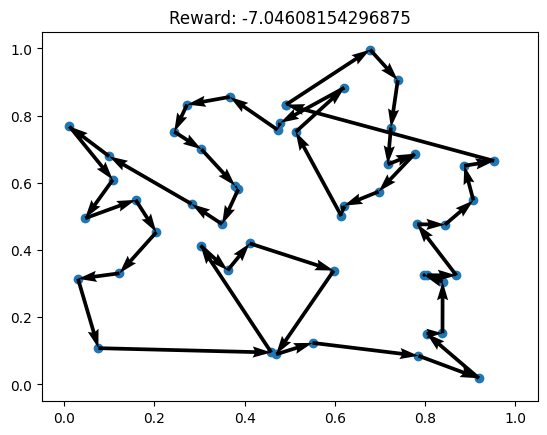

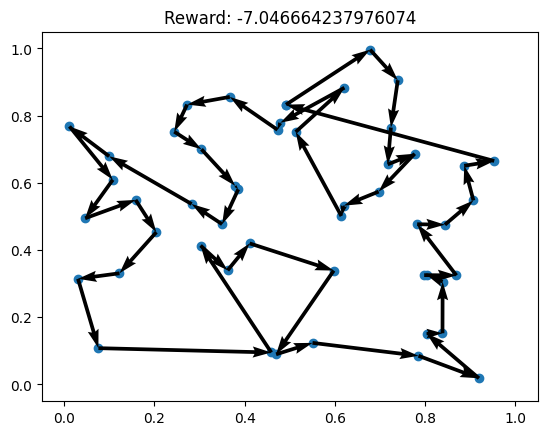

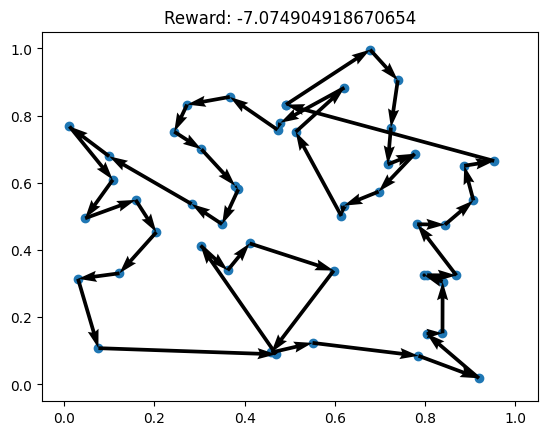

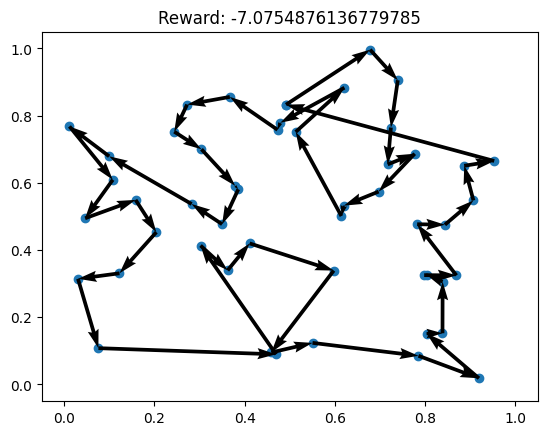

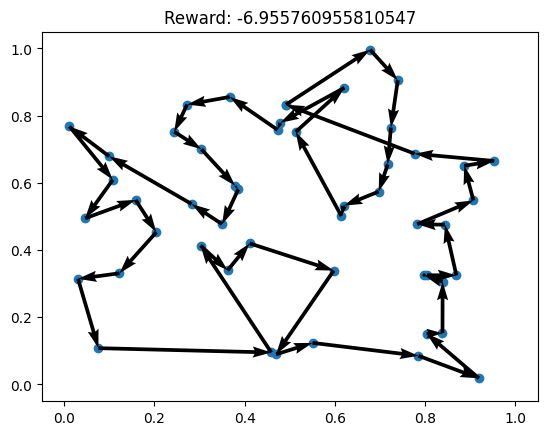

In [95]:
import matplotlib.pyplot as plt
batch_instance = 0
for i, actions in enumerate(actions_stacked[batch_instance].cpu()):
    reward = rewards_stacked[batch_instance, i]
    _, ax = plt.subplots()
    
    env.render(td[0], actions, ax=ax)
    ax.set_title("Reward: %s" % reward.item())

### Final notes

For evaluation, we can also use additional decoding strategies used during evaluatin, such as sampling N times or greedy augmentations, available in [rl4co/tasks/eval.py](../../rl4co/tasks/eval.py)